In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from src.misc import *
from src.model_search import *
from src.model_utils import *

with pd.HDFStore('data/preprocessed_data/feat_h_split_comb.h5', mode='r') as store:
    X_train = store['X_train']
    y_train = store['y_train']
    X_val = store['X_val']
    y_val = store['y_val']
    X_test = store['X_test']
    y_test = store['y_test']

    labels_train = store['labels_train']
    labels_val = store['labels_val']
    labels_test = store['labels_test']

X_train_norm,X_val_norm, norm_model = normalize_features(X_train,X_val)
X_train_norm,X_test_norm,_ = normalize_features(X_train,X_test)

In [2]:
from preprocess_hyper.prep_func import *
import pickle

prep_h = pickle.load(open('data/preprocessed_data/prep_h.pkl', 'rb'))
# Create a list of functions to apply to the images
def max_min(image):
    ratio = image.max() / (image.min()+0.0001)
    return np.where(ratio > 30, np.nan, ratio)
functions = [(np.linalg.norm, {'axis': 0}),
             (max_min, {})]

# Apply the functions to the images
d_range_h = pd.DataFrame(apply_functions_to_images(prep_h, functions))

Dr_h = pd.Series(np.nanmean(d_range_h, axis=0), index=d_range_h.columns)

Processing images: 100%|██████████| 394/394 [00:00<00:00, 518.56it/s]


#### functions

In [3]:
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import r2_score, mean_squared_error

def get_hyperparam_feat(df, index=0):
    '''
    Function to return hyperparameter config and selected features from dataframe of scores
    index =0 mean the hyperparameter for the highet r2_adj
    '''
    # Get the column names
    column_names = df.columns.tolist()

    # Find the index of 'r2_train'
    r2_train_index = column_names.index('num_features')

    # Select every column before 'r2_train'
    selected_columns = df.iloc[:, :r2_train_index]

    # Convert the DataFrame to a dictionary
    result_dict = selected_columns.to_dict('index')

    # Get the id of the best hyperparameter
    id = df.sort_values(by='r2_adj',ascending=False).index[index]

    # Get feature
    if type(df['selected_features'][id]) == str:
        df['selected_features'] = df['selected_features'].apply(ast.literal_eval)
    feat = df['selected_features'][id]
    return result_dict[id], feat

def plot_with_flight_num(predicted, actual, labels, title, plot_number=True, save_fig=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # circle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # triangle
        elif str(flight_number).startswith('2023'):
            marker = 'o'  # x

        plt.scatter(actual[mask], predicted[mask], s=100, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=3)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def plot_with_flight_num2(predicted, actual, labels, title, std_dev = None, plot_number=False, save_fig=None, flt_to_plot=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        predicted = predicted[mask]
        actual = actual[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(actual[mask], predicted[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(actual[mask], predicted[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=2, fontsize=13)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate2(model, feat, labels, title, plt_num=True, save_fig=None):
    print('Train score: ',model.score(X_train_norm[feat],y_train), ' RMSE:',mean_squared_error(y_train, model.predict(X_train_norm[feat]), squared=False))
    print('Validation score: ',model.score(X_val_norm[feat],y_val), ' RMSE:',mean_squared_error(y_val, model.predict(X_val_norm[feat]), squared=False))
    print('Test score: ',model.score(X_test_norm[feat],y_test), ' RMSE:',mean_squared_error(y_test, model.predict(X_test_norm[feat]), squared=False))

    plot_with_flight_num2(model.predict(X_test_norm[feat])*100,y_test*100,labels, title=title, plot_number=plt_num,save_fig=save_fig)

def evaluate_model_by_flight_combined(model, feat, X, y, labels_):
    # This function evaluates a given model's performance by flight group. It calculates R-squared 
    # and RMSE metrics for the combined dataset for each unique flight group in the dataset. 
    # The function requires the model, features (feat), and labels containing flight information. 
    # It returns a DataFrame with flight groups as the index and the evaluation metrics for each dataset.
    
    labels = labels_.copy()  # Copy labels to avoid modifying the original DataFrame
    results = []  # Initialize results list
    labels['FlightGroup'] = labels['Flight'].astype(str).str[:4]  # Extract the first four digits of the 'Flight' column
    unique_flight_groups = labels['FlightGroup'].unique()  # Get unique flight groups from labels

    for flight_group in unique_flight_groups:  # Iterate over each unique flight group
        # Filter datasets for the current flight group
        mask = labels['FlightGroup'] == flight_group
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))

        # Append the results
        results.append({
            'FlightGroup': flight_group,
            '$R^2$': r2_combined,
            'RMSE (%)': rmse_combined
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('FlightGroup', inplace=True)
    
    return results_df


In [91]:
def evaluate_model_by_flight_combined(model, feat, X, y, labels_):
    # This function evaluates a given model's performance by flight group. It calculates R-squared 
    # and RMSE metrics for the combined dataset for each unique flight group in the dataset. 
    # The function requires the model, features (feat), and labels containing flight information. 
    # It returns a DataFrame with flight groups as the index and the evaluation metrics for each dataset.
    
    labels = labels_.copy()  # Copy labels to avoid modifying the original DataFrame
    results = []  # Initialize results list
    
    # Create a new column to group 2021 and 2022 together, and keep 2023 separate
    labels['FlightGroup'] = labels['Flight'].astype(str).str[:4].replace({'2021': '2021-2022', '2022': '2021-2022'})
    
    unique_flight_groups = labels['FlightGroup'].unique()  # Get unique flight groups from labels

    for flight_group in unique_flight_groups:  # Iterate over each unique flight group
        # Filter datasets for the current flight group
        mask = labels['FlightGroup'] == flight_group
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))

        # Append the results
        results.append({
            'FlightGroup': flight_group,
            '$R^2$': r2_combined,
            'RMSE (%)': rmse_combined
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('FlightGroup', inplace=True)
    
    return results_df

## RF with multispec feats

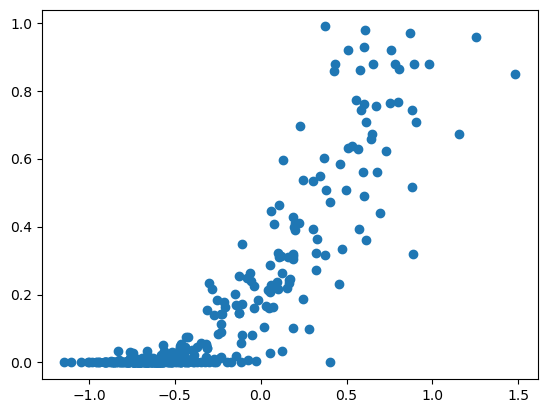

In [28]:
plt.scatter(Data['rdvi_skewness'], Data['CLS_score'])

In [24]:
Data=pd.read_csv('data/preprocessed_data/feat_h.csv', header=0) 

Data.loc[(Data['Flight']==20210720) & (Data['Plot']==4)]

,Flight,Plot,clsi_mean,clsi_cv,clsi_q1,clsi_q3,clsi_skewness,clsi_kurtosis,hi_mean,hi_cv,...,tex_cor_kurtosis_71,tex_cor_kurtosis_72,tex_cor_kurtosis_73,tex_cor_kurtosis_74,tex_cor_kurtosis_75,tex_cor_kurtosis_76,tex_cor_kurtosis_77,tex_cor_kurtosis_78,tex_cor_kurtosis_79,CLS_score
114,20210720,4,-0.606273,-0.179523,-0.678497,-0.544424,0.568921,1.084593,0.288368,0.343831,...,2.788268,2.845663,2.740867,2.648603,2.972419,2.615165,2.653678,2.858305,2.556315,0.0


In [92]:
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameters and their possible values
hyperparameters = {
    'n_estimators': [25, 50, 100, 200, 500, 700, 1000, 1200],
    'max_depth': [3, 5, 8, 12, 15, 18],
    # Fixed hyperparameter
    'min_samples_split': [3],
    'min_samples_leaf': [2],
    'max_features': ['log2'],
    'random_state': [42]
}
def r_f_feat_imp(model,X,y):
    if not isinstance(model, RandomForestRegressor):
        raise ValueError("Model must be a RandomForestRegressor instance")

    return model.feature_importances_


feat = ['rdvi_skewness', 'tex_homo_cv_66']  # 66 corresponds to 841 nm

# Perform the grid search and save the results
result_rf = grid_search_(RandomForestRegressor, X_train_norm[feat], y_train, X_val_norm[feat], y_val, hyperparameters)

Processing:   0%|          | 0/48 [00:00<?, ?it/s]c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
s:\ms4667\Analysis\disease_analysis\cls_multispec_uas\src\model_search.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({**hyperparams, 'num_features': num_features, 'selected_features': selected_features,
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_reg

In [34]:
result_rf.sort_values(by='r2_adj',ascending=False).head(5)

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,random_state,num_features,selected_features,r2_train,rmse_train,r2_val,rmse_val,r2_adj
8,50,8,3,2,log2,42,2,"[rdvi_skewness, tex_homo_cv_66]",0.934128,0.058043,0.793496,0.093460,0.791592
22,200,15,3,2,log2,42,2,"[rdvi_skewness, tex_homo_cv_66]",0.938450,0.056106,0.784614,0.095448,0.782629
29,500,18,3,2,log2,42,2,"[rdvi_skewness, tex_homo_cv_66]",0.939529,0.055612,0.783260,0.095748,0.781262
23,200,18,3,2,log2,42,2,"[rdvi_skewness, tex_homo_cv_66]",0.937673,0.056459,0.783208,0.095759,0.781210
28,500,15,3,2,log2,42,2,"[rdvi_skewness, tex_homo_cv_66]",0.939782,0.055496,0.783098,0.095784,0.781099


c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.9678375932103583  RMSE: 0.04055754032551392
Validation score:  0.7725791268287112  RMSE: 0.0980786143960807
Test score:  0.8731748597393452  RMSE: 0.10137289050507263


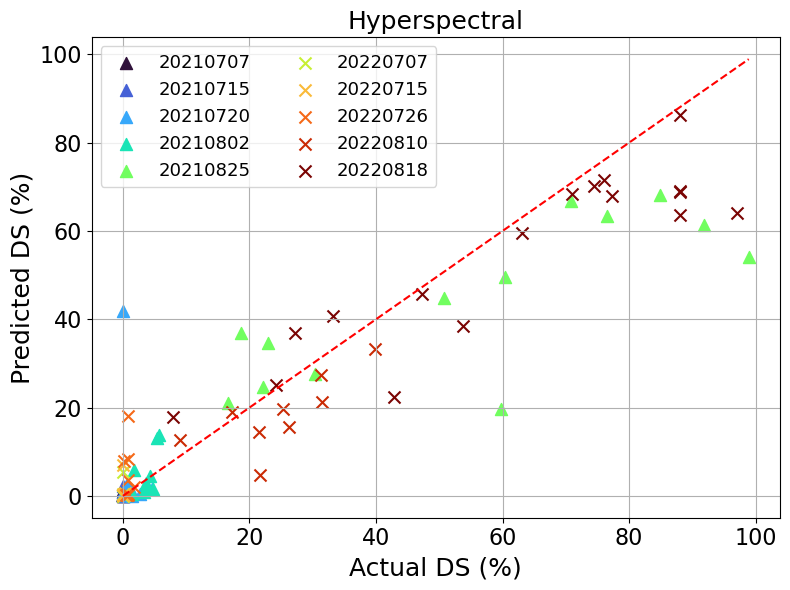

In [99]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, max_depth=8).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='Hyperspectral', plt_num=False)#, save_fig='figures/RF_test.png')

#### Comparing with dynamic range

In [52]:
import pandas as pd

def create_err_matrix(model, X_scaled, y, labels, feat):
    """
    Create an error matrix by predicting with the model and appending the error and standard deviation to the labels.

    Parameters:
    - model: The trained model to use for predictions.
    - scaler: The scaler used to transform the features.
    - X: The input features for prediction.
    - y: The true values.
    - labels: The DataFrame containing the labels.
    - feat: The list of features to use for prediction.

    Returns:
    - err_matrix: A DataFrame containing the labels, error, and standard deviation.
    """
    # Predict with the model
    pred = model.predict(X_scaled[feat])
    
    # Calculate the error
    err = pred - y
    
    # Create a copy of the labels DataFrame
    err_matrix = labels.copy()
    
    # Append the error to the labels DataFrame
    err_matrix['err'] = err
    
    return err_matrix

# Create the error matrix for the RF model
err_matrix_rf_test = create_err_matrix(model, X_test_norm, y_test, labels_test, feat)
err_matrix_rf = create_err_matrix(model, 
                                  pd.concat([X_train_norm, X_val_norm, X_test_norm]), 
                                  pd.concat([y_train, y_val, y_test]), 
                                  pd.concat([labels_train, labels_val, labels_test]), 
                                  feat)

In [57]:
rmse_h = err_matrix_rf.groupby('Flight')['err'].apply(lambda x: np.sqrt(np.nanmean(x**2)))

Text(0, 0.5, 'RMSE')

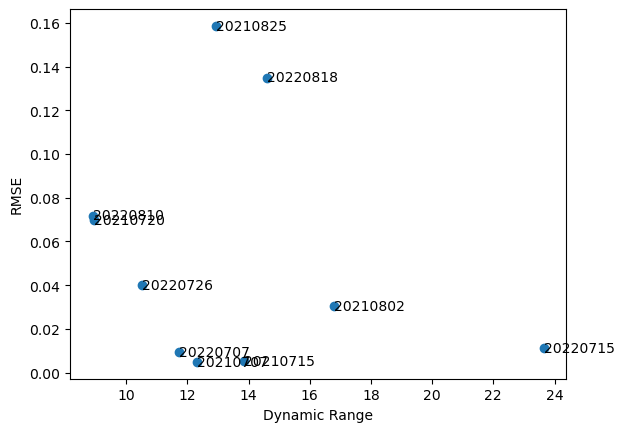

In [60]:
plt.scatter(Dr_h, rmse_h)
for i, txt in enumerate(Dr_h.index):
    plt.annotate(txt, (Dr_h.iloc[i], rmse_h.iloc[i]), fontsize=10, va='center')
plt.xlabel('Dynamic Range')
plt.ylabel('RMSE')

<Axes: ylabel='Flight'>

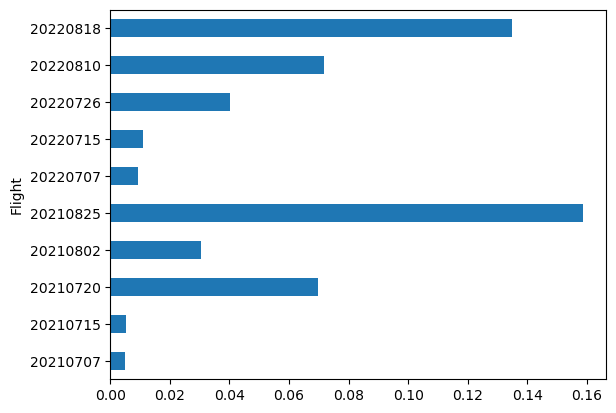

In [61]:
rmse_h.plot.barh()

In [72]:

def add_dynamic_range(err_matrix, DR):
    """
    Add a "Dynamic Range" column to the err_matrix based on the 'Flight' and 'Plot' columns.

    Parameters:
    - err_matrix (pd.DataFrame): The input DataFrame containing 'Flight' and 'Plot' columns.
    - DR (pd.DataFrame): The DataFrame containing the "Dynamic Range" values.

    Returns:
    - err_matrix (pd.DataFrame): The updated DataFrame with the "Dynamic Range" column added.
    """
    # Check if 'Flight' and 'Plot' columns exist in err_matrix
    if 'Flight' not in err_matrix.columns or 'Plot' not in err_matrix.columns:
        raise ValueError("The 'Flight' and 'Plot' columns must be present in the err_matrix.")

    # Initialize an empty list to store the "Dynamic Range" values
    dynamic_range_values = []

    # Iterate over the rows of the err_matrix
    for _, row in err_matrix.iterrows():
        flight = str(int(row['Flight']))
        plot = row['Plot']
        # Retrieve the corresponding "Dynamic Range" value from the DR matrix
        dynamic_range_value = DR.at[plot, flight]
        dynamic_range_values.append(dynamic_range_value)

    # Add the "Dynamic Range" values to the err_matrix
    err_matrix['Dynamic Range'] = dynamic_range_values

    return err_matrix
#DR_m = pd.DataFrame(d_range_m)
#DR_h = pd.DataFrame(d_range_h)

add_dynamic_range(err_matrix_rf, d_range_h)

,Flight,Plot,err,Dynamic Range
294,20220726,29,0.005915,7.205227910295353
359,20220818,15,0.066794,13.267346035715713
393,20220818,9,-0.032291,nan
103,20210720,31,0.008177,8.296734292676767
264,20220715,38,0.001311,20.088840127239866
...,...,...,...,...
280,20220726,16,0.199561,13.034222753950534
354,20220818,10,-0.041839,7.896140515912903
249,20220715,24,0.001878,23.90490306600405
153,20210802,9,-0.011258,17.04472550037648


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


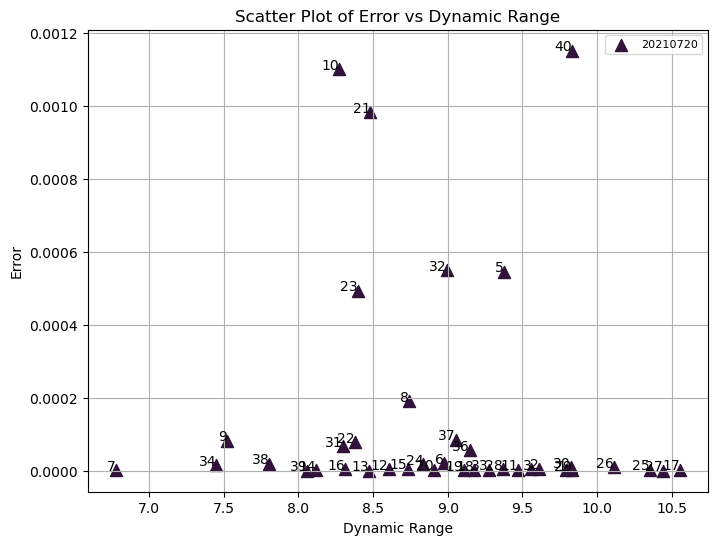

In [75]:
## Plotting the error vs dynamic range (all points)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_err_vs_dynamic_range(err_matrix_in, err_std='err', flt_to_plot = None, std_dev = None, plot_number = False):
    """
    Plot a scatter plot of 'err' vs 'Dynamic Range' with different types of points based on 'Flight'.

    Parameters:
    - err_matrix (pd.DataFrame): The input DataFrame containing 'err', 'Dynamic Range', and 'Flight' columns.
    """
    err_matrix = err_matrix_in.copy()
     # Extract the 'Flight' column
    flight_column = err_matrix['Flight']
    plot_column = err_matrix['Plot']

    err_y = err_matrix[err_std]**2
    err_x = err_matrix['Dynamic Range'] 
    
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        err_y = err_y[mask]
        err_x = err_x[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]
    
    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)
    # Create a scatter plot using seaborn
    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(err_x[mask], err_y[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(err_x[mask], err_y[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(err_x.iloc[i], err_y.iloc[i], f'{plot_num}', fontsize=10, ha='right') 
    # Set labels and title
    plt.xlabel('Dynamic Range')
    plt.ylabel('Error')
    plt.title('Scatter Plot of Error vs Dynamic Range')
    plt.grid(True)
    
    # Clip the x-axis to a specific range
    #plt.xlim(2, 15)

    plt.legend(loc = 'upper right', ncol=1, fontsize=8)
    
    # Show the plot
    plt.show()
plot_err_vs_dynamic_range(err_matrix_rf, flt_to_plot=[20210720],plot_number=True)

#### Training multispec data

In [38]:
feat

['rdvi_skewness', 'tex_homo_cv_4']

In [39]:
from sklearn.ensemble import RandomForestRegressor

with pd.HDFStore('data/preprocessed_data/feat_split_comb.h5', mode='r') as store:
    X_train_m = store['X_train']
    y_train_m = store['y_train']
    X_val_m = store['X_val']
    y_val_m = store['y_val']
    X_test_m = store['X_test']
    y_test_m = store['y_test']

    labels_train_m = store['labels_train']
    labels_val_m = store['labels_val']
    labels_test_m = store['labels_test']

X_train_norm_m,X_val_norm_m, norm_model_m = normalize_features(X_train_m,X_val_m)
X_train_norm_m,X_test_norm_m,_ = normalize_features(X_train_m,X_test_m)

result_rf = pd.read_csv('mod_opt/model_scores/rf_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_rf, index=0)


model = RandomForestRegressor(**hyperparameters).fit(X_train_norm_m[feat],y_train_m)
#model_evaluate2(model, feat, labels_test, title='RF', plt_num=False)

In [41]:
model.score(X_test_norm['rdvi_skewness', 'tex_homo_cv_66'],y_test)

KeyError: ('rdvi_skewness', 'tex_homo_cv_66')

## RF

In [53]:
hyperparameters

{'n_estimators': 25,
 'max_depth': 12,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'random_state': 42}

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.9497020751822213  RMSE: 0.0507191973510909
Validation score:  0.8951199548845863  RMSE: 0.06660480990846845
Test score:  0.8748623356290168  RMSE: 0.10069622201886395


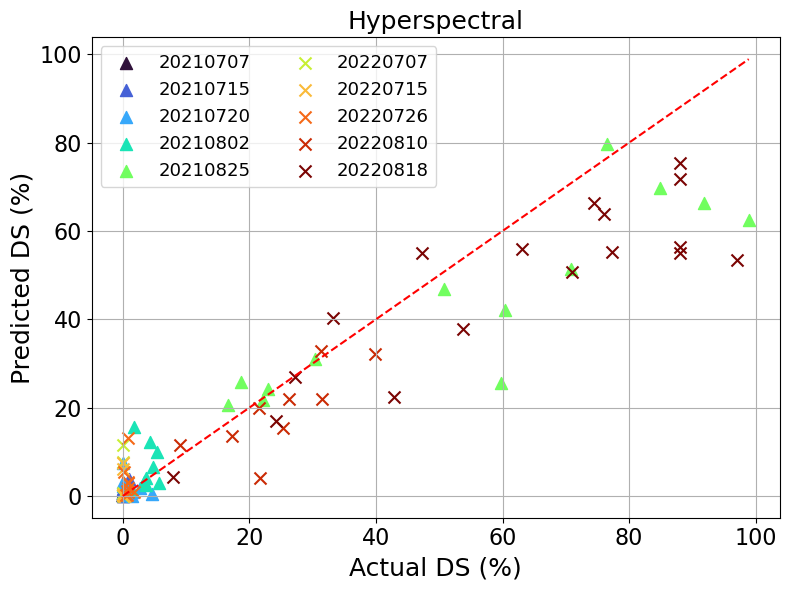

In [45]:
from sklearn.ensemble import RandomForestRegressor

result_rf = pd.read_csv('mod_opt_hyper/model_scores/rf_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_rf, index=0)

model = RandomForestRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='Hyperspectral', plt_num=False)

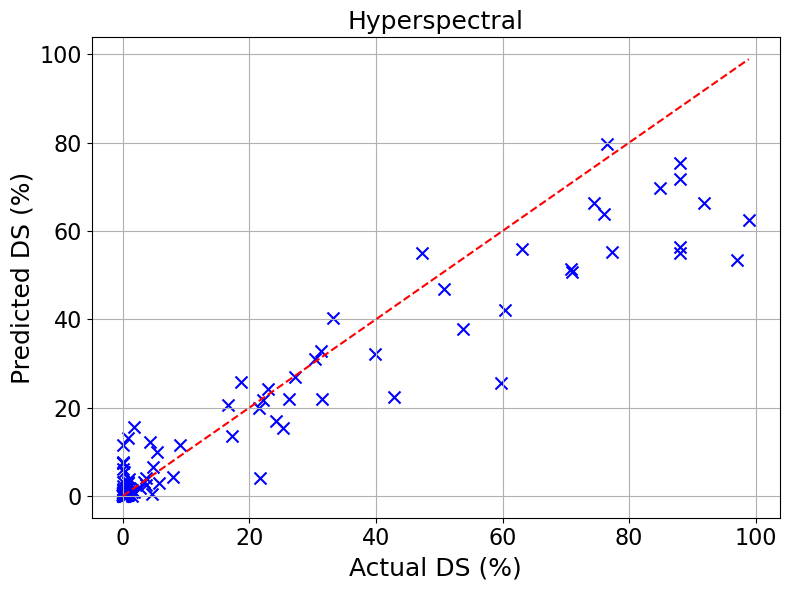

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test*100,model.predict(X_test_norm[feat])*100, s =75, color= 'blue', marker = 'x')
plt.plot([min(y_test*100), max(y_test*100)], [min(y_test*100), max(y_test*100)], color='red', linestyle='--')
plt.xlabel('Actual DS (%)', fontsize=18)
plt.ylabel('Predicted DS (%)', fontsize=18)
plt.title('Hyperspectral', fontsize=18)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
plt.tight_layout()
plt.show()

In [13]:
#Load wavelength bands
lb, ub = 0, 80
hyper_wave = np.linspace(398.573,1001.81,272)
hyper_wave_3 = dn_sample_sig(hyper_wave, 3)[lb:ub]

In [49]:
hyper_wave_3[51]

741.3718856088559

In [52]:
X_train_norm[feat].to_csv('X_train_norm.csv')
X_test_norm[feat].to_csv('X_test_norm.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [47]:
feat

['mcari2_skewness',
 'tex_homo_cv_48',
 'tex_homo_kurtosis_51',
 'tex_dis_skewness_54']

## XGBoost

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.9995727202981848  RMSE: 0.004674697030938969
Validation score:  0.9239057990728502  RMSE: 0.05673289437942653
Test score:  0.8173041997112349  RMSE: 0.12166997992369243


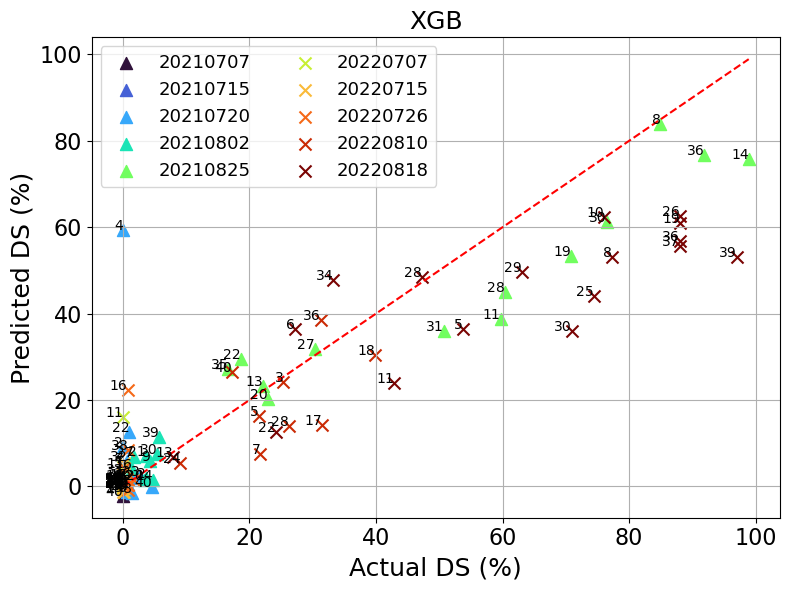

In [8]:
import xgboost as xgb

result_xgb = pd.read_csv('mod_opt_hyper/model_scores/xgb_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_xgb, index=0)

model = xgb.XGBRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat,labels_test, title='XGB', plt_num=True)#, save_fig='figures/XGB_test.png')

In [24]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.966615  0.044789
2023         0.780629  0.072696
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.526771  0.135307
2021-2022    0.917814  0.065591


## SVR

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.9999984343480203  RMSE: 0.0002829729706979606
Validation score:  0.8948939497007644  RMSE: 0.066676534379986
Test score:  0.769496793496236  RMSE: 0.13666510517352956


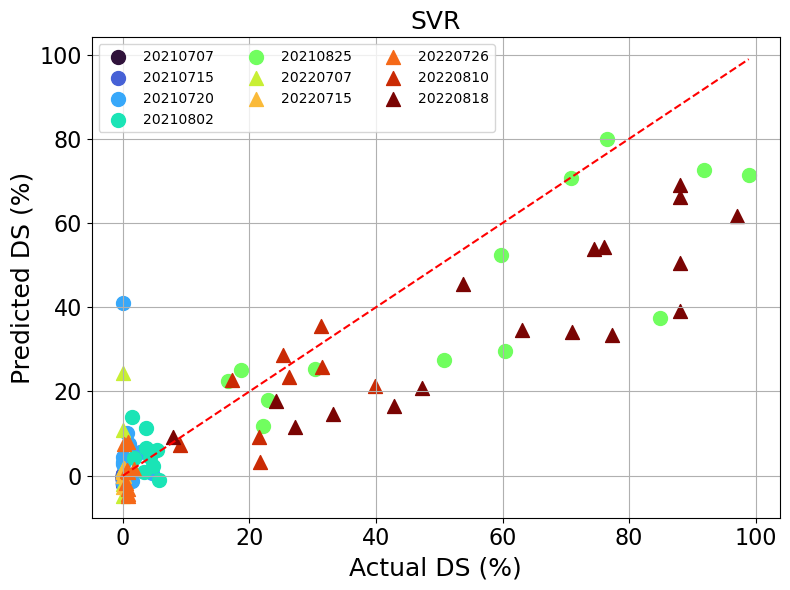

In [15]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

result_svr = pd.read_csv('mod_opt_hyper/model_scores/svr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_svr, index=0)

model = SVR(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='SVR', plt_num=False)#, save_fig='figures/SVR_test.png')

In [26]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.954011  0.052568
2023         0.600796  0.098066
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.528357  0.135080
2021-2022    0.880306  0.079156


## GPR

In [86]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error # type: ignore

def gaussian_process_regression_with_tuning(X_train, y_train, X_test, y_test, print_results=True):
    """
    Perform Gaussian Process Regression with hyperparameter tuning on the given training data,
    and predict the output for the test data.

    Parameters:
    - X_train: Training features.
    - y_train: Training targets.
    - X_test: Test features to predict.

    Returns:
    - y_pred: Predicted values for X_test.
    - model: The fitted Gaussian Process Regressor model with the best found hyperparameters.
    """
    # Define different kernel functions
    kernels = [
        C(1.0, (1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3)),
        #C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.5),
        #C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), alpha=0.1),
        #C(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), periodicity=3.0),
        #C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))
    ]
    
    # Setup hyperparameter space for tuning
    param_grid = {
        "alpha": [0.05, 0.1, 0.5, 1],
        "kernel": kernels
    }
    # Instantiate a Gaussian Process Regressor
    gpr = GaussianProcessRegressor(n_restarts_optimizer=10)
    
    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(gpr, param_grid=param_grid, cv=5, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Best model after tuning
    model = grid_search.best_estimator_
    
    # Make predictions using the best found model
    #y_pred = model.predict(X_test)
    if print_results:
        print(f'Model score: {model.score(X_test,y_test)}')
    return model, grid_search

from tkinter import font
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
import ast

def plot_with_flight_num(predicted, actual, labels, title, std_dev = None, plot_number=False, save_fig=None, flt_to_plot=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        predicted = predicted[mask]
        actual = actual[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(actual[mask], predicted[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(actual[mask], predicted[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual root yield (kg/m$^2$)', fontsize=18)
    plt.ylabel('Predicted root yield (kg/m$^2$)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=2, fontsize=13)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate3(model, feat, labels, title, X_train, y_train, X_test, y_test, err_bar=False, plt_num=False, save_fig=None):
    _,train_std = model.predict(X_train[feat], return_std=True)
    predicted_mean, predicted_std = model.predict(X_test[feat], return_std=True)
    print('Train score: ',model.score(X_train[feat],y_train), ' RMSE:',root_mean_squared_error(y_train, model.predict(X_train[feat])), ' MAPE:',mean_absolute_percentage_error(y_train, model.predict(X_train[feat])), ' std_dev:',train_std.mean())
    #print('Validation score: ',model.score(X_val[feat],y_val), ' RMSE:',mean_squared_error(y_val, model.predict(X_val[feat]), squared=False))
    print('Test score: ',model.score(X_test[feat],y_test), ' RMSE:',root_mean_squared_error(y_test, model.predict(X_test[feat])), ' MAPE:',mean_absolute_percentage_error(y_test, model.predict(X_test[feat])), ' std_dev:',predicted_std.mean())

    if err_bar:
        plot_with_flight_num(predicted_mean, y_test, labels, title=title, std_dev=predicted_std, plot_number=plt_num, save_fig=save_fig)
    else:
        plot_with_flight_num(model.predict(X_test[feat]),y_test,labels, title=title, plot_number=plt_num,save_fig=save_fig)

def evaluate_model_by_flight_combined(model, feat, X, y, labels, rmse= False, std=False):
    # This function evaluates a given model's performance by flight. It calculates R-squared 
    # and RMSE metrics for training, validation, and test datasets separately for each 
    # unique flight in the dataset. The function requires the model, features (feat), and 
    # labels containing flight information. It returns a DataFrame with flights as the 
    # index and the evaluation metrics for each dataset.
    results = []  # Initialize results list
    unique_flights = labels['Flight'].unique()  # Get unique flights from labels

    for flight in unique_flights:  # Iterate over each unique flight
        # Filter datasets for the current flight
        mask = labels['Flight'] == flight
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))
        mape_combined = mean_absolute_percentage_error(y_flt, model.predict(X_flt[feat]))

        # Append the results
        results.append({
            'Flight': flight,
            '$R^2$': r2_combined,
            'MAPE (%)': mape_combined*100
        })
        if rmse:
            results[-1]['RMSE ($kg/m^2$)'] = rmse_combined
        if std:
            _, predicted_std = model.predict(X_flt[feat], return_std=True)
            results[-1]['std_dev ($kg/m^2$)'] =  predicted_std.mean()

    # Return the results as a DataFrame with 'Flight' as the index
    df = pd.DataFrame(results)
    df.set_index('Flight', inplace=True)
    return df

In [87]:
model, grid = gaussian_process_regression_with_tuning(X_train_norm[feat], y_train, X_val_norm[feat], y_val, print_results=True)

Model score: 0.8090710834743464


In [88]:
model_evaluate3(model, feat, labels_test, title='GPR', X_train=X_train_norm, y_train=y_train, X_test=X_val_norm, y_test=y_val, err_bar=True, plt_num=False)#, save_fig='figures/GPR_test.png')

Train score:  0.8505598090738049  RMSE: 0.08742407486737953  MAPE: 29380562837251.637  std_dev: 0.0332484207734053
Test score:  0.8090710834743464  RMSE: 0.08986591786495964  MAPE: 21852565662808.914  std_dev: 0.03221452421383679


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Figure size 800x600 with 0 Axes>

Train score:  0.8505598090738049  RMSE: 0.08742407486737953  MAPE: 29380562837251.637  std_dev: 0.0332484207734053
Test score:  0.8746776887014224  RMSE: 0.10077048580805427  MAPE: 37518714627627.484  std_dev: 0.034354047130115695


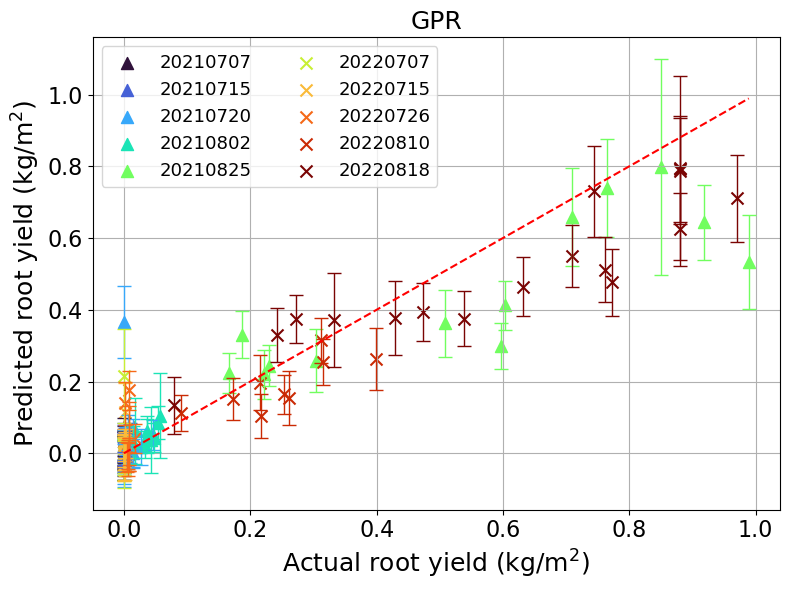

In [89]:
model_evaluate3(model, feat, labels_test, title='GPR', X_train=X_train_norm, y_train=y_train, X_test=X_test_norm, y_test=y_test, err_bar=True, plt_num=False)#, save_fig='figures/GPR_test.png')